<h1 style="color:blue;"> Predicting the Chance for Graduate Admission</h1>

# Business Problem:

Analyze the data to understand what factors are important in graduate admissions and how these factors are interrelated among themselves.

# Importing Libaries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from prettytable import PrettyTable

# Understanding the Data

## Quick Look at the data

__Loading the Data__

In [3]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

__Data Dimension__

In [4]:
df.shape

(500, 9)

__Summary:__

We have 500  data points, and 9 features

__How the data looks like?__

In [5]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


__Column names:__

In [6]:
df.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

**We have following informations about the columns:**
<ul>
<li>Serial No. (Unique row ID)</li>
<li>GRE Scores (out of 340)</li>
<li>TOEFL Scores (out of 120)</li>
<li>University Rating (out of 5)</li>
<li>Statement of Purpose and Letter of Recommendation Strength (out of 5)</li>
<li>Undergraduate GPA (out of 10)</li>
<li>Research Experience (either 0 or 1)</li>
<li>Chance of Admit (ranging from 0 to 1)</li>
</ul>

Here `Serial No` is a unique identifier. So we will drop it from our further analysis.

In [7]:
df.drop(columns=['Serial No.'], inplace=True)
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


__Checking the data types of the columns__

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


__Summary__

- We have following types of attributes: `float` and `int`


## Some basic checks


### Fixing any discrepansies in dtype

In [9]:
def iqr(x):
    return x.quantile(q=0.75) - x.quantile(q=0.25)

def quantile_boundaries(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)
    return (lower_out, upper_out)

## Outlier > 75th %tile + 1.5IQR & < 25th %tile - 1.5IQR
def outlier_count(x):
    upper_out = x.quantile(q=0.75) + 1.5 * iqr(x)
    lower_out = x.quantile(q=0.25) - 1.5 * iqr(x)

    return len(x[x > upper_out]) + len(x[x < lower_out])

In [10]:
def stats_summary(df, type):
    """
    Method to display statistical summaries for categorical and numerical columns

    Arguments:
        df: a data frame object
        type: the dtype for which summaries will be computed.
            Accepts two values: either 'numeric' or 'category'

    Returns:
        A dataframe object containing statistical summaries
    """
    if type=='numeric':
        df_num = df._get_numeric_data()
        df_stats = df_num.describe().T
        try:
            vals = []
            unique = []
            for c in df_num.columns:
                vals.append(outlier_count(df_num[c]))
                unique.append(df_num[c].nunique())
            df_stats['Count of Outliers'] = vals
            df_stats['Unique Values'] = unique
        except:
            pass
        return df_stats

    elif type=='category':
        df_cat = df.select_dtypes(['category'])
        df_stats = df_cat.describe().T

        try:
            vals = []
            for c in df_cat.columns:
                vals.append((df_cat[df_cat[c].isnull()].shape[0]*100) / df_cat.shape[0])
            df_stats['Missing Percentage'] = vals
        except:
            pass
        return df_stats

    else:
        raise Exception('Legal type params are {"numeric", "category"}') 

In [11]:
def datatype_conversion(df, columns, target_type):
    """
    Method to convert the type of columns in "columns" to "target_type"
    """
    convert_dict = dict(zip(columns, [target_type]*len(columns)))
    df = df.astype(convert_dict)
    return df

def datatype_information(df):
    """
    Method to display "dtype" for each column
    """
    datatype_info = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        datatype_info.loc[0, col] = df[col].dtype
    return datatype_info

In [12]:
df.select_dtypes([np.number]).head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [13]:
stats_summary(df, 'numeric')

,count,mean,std,min,25%,50%,75%,max,Count of Outliers,Unique Values
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00,0,49
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00,0,29
University Rating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00,0,5
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00,0,9
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00,1,9
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92,0,184
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00,0,2
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97,2,61


__Findings:__
- The unique values count for the attributes "University Rating", "SOP", "LOR", and "Research" are less. We can treat them as categorical.

__Fixing the dtype:__

In [14]:
df = datatype_conversion(df, ['University Rating', 'SOP', 'LOR ', 'Research'], 'category')
datatype_information(df)

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,int64,int64,category,category,category,float64,category,float64


__Summary__

- We fixed the incorrect datatypes

### Checking missing values

In [15]:
def missing_val_overview(df):

    ## Creating Empty Data Frame
    data_info = pd.DataFrame(np.random.randn(0, 5) * 0,
                             columns=['No. of Rows with missing values',
                                      'No. of columns with zero missing cases',
                                      'No. of columns with >0 and <=50% missing cases',
                                      'No. of columns with >50% missing cases',
                                      'No. of columns with >90% missing cases'])

    ## Data Inofrmation
    data_info.loc[0, 'No. of Rows with missing values'] = df.isna().any(axis=1).sum()
    
    null_per = pd.DataFrame(df.isna().sum()/df.shape[0])
    null_per.columns = ['null_per']
    data_info.loc[0, 'No. of columns with zero missing cases']  = null_per[null_per.null_per == 0.0].shape[0] 
    data_info.loc[0, 'No. of columns with >0 and <=50% missing cases'] = null_per[(null_per.null_per <= 0.50) & (null_per.null_per > 0)].shape[0] 
    data_info.loc[0, 'No. of columns with >50% missing cases']  = null_per[null_per.null_per > 0.50].shape[0]
    data_info.loc[0, 'No. of columns with >90% missing cases']  = null_per[null_per.null_per > 0.90].shape[0]
    
    ## Transposing Data to get in consumable format
    data_info = data_info.transpose()
    data_info.columns = ['Value']
    data_info['Value'] = data_info['Value'].astype(int)

    return data_info

In [16]:
missing_val_overview(df)

,Value
No. of Rows with missing values,0
No. of columns with zero missing cases,8
No. of columns with >0 and <=50% missing cases,0
No. of columns with >50% missing cases,0
No. of columns with >90% missing cases,0


**Summary**
- There are no missing values in the dataset

## Statistical Summary:

### Numerical Stats

In [17]:
stats_summary(df, 'numeric')

,count,mean,std,min,25%,50%,75%,max,Count of Outliers,Unique Values
GRE Score,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00,0,49
TOEFL Score,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00,0,29
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92,0,184
Chance of Admit,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97,2,61


__Observation__:
- We have outliers in the numerical column. We will try to make sense of the outliers in our further analysis
- There are no missing values

**Note:** The outliers are the data points lying outside the range `[25th %tile - 1.5IQR, 75th %tile + 1.5IQR]`

The fence values are computed as illustrated in the image below:

![](http://www.nathalievialaneix.eu/teaching/biostat1/img/boxplot_explanation.png)

### Categorical Count Stats

In [18]:
stats_summary(df, 'category')

,count,unique,top,freq,Missing Percentage
University Rating,500.0,5.0,3.0,162.0,0.0
SOP,500.0,9.0,4.0,89.0,0.0
LOR,500.0,9.0,3.0,99.0,0.0
Research,500.0,2.0,1.0,280.0,0.0


__Observation:__
- we have 4 categorical features
- there are no missing values 

# EDA

We did some surface scratching and found some basic details. Now we will do in depth exploration of the dataset and try to come up with some possible actionable insights.

## Univariate Analysis

In [19]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

### Categorical Attributes

In [20]:
def make_categorical_plots(df, feature):
    """
    Method to make univariate categorical plot
    """

    # creating a figure composed of two matplotlib.Axes objects (ax_count and ax_pie)
    f, (ax_count, ax_pie) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    data = df[feature].value_counts()

    sns.countplot(data=df, x=feature, order=data.index, ax=ax_count)
    for p in ax_count.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax_count.annotate('{}'.format(int(y)), (x.mean(), y), 
                ha='center', va='bottom')

    #customize plot
    params = {
        'autopct':'%.0f%%',
        'startangle': 90,
        'radius': 1,
        'wedgeprops': {'linewidth': 3},
        'explode': (0.01,)*df[feature].nunique(),
        'textprops': {'size': 'large'}
    }
    #create pie chart
    ax_pie.pie(data.values, labels = data.index, **params)
    plt.show()

#### University Rating

In [21]:
df['University Rating'].value_counts()

3    162
2    126
4    105
5     73
1     34
Name: University Rating, dtype: int64

In [22]:
df['University Rating'].unique()

[4, 3, 2, 5, 1]
Categories (5, int64): [1, 2, 3, 4, 5]

__Findings:__
- The universities are categorized into 5 unique ratings

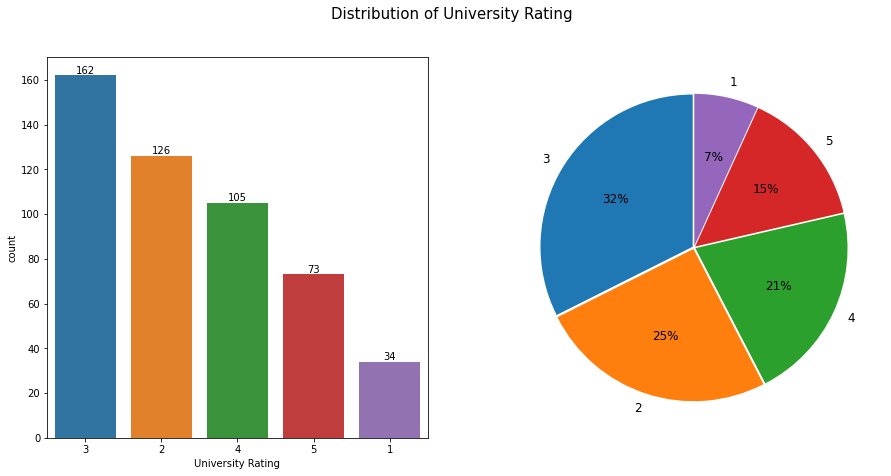

In [23]:
make_categorical_plots(df, 'University Rating')

__Findings:__
- Most of the students come from Universities with Rating 3
- Fewer students come from Universities with Rating 1, and 5

#### SOP rating

In [24]:
df.SOP.value_counts()

4.0    89
3.5    88
3.0    80
2.5    64
4.5    63
2.0    43
5.0    42
1.5    25
1.0     6
Name: SOP, dtype: int64

In [25]:
df.SOP.nunique()

9

__Findings:__
- The SOPs are rated in 9 different numbers, ranging from 1-5 (1.0, 1.5, ..., 4.5, 5)

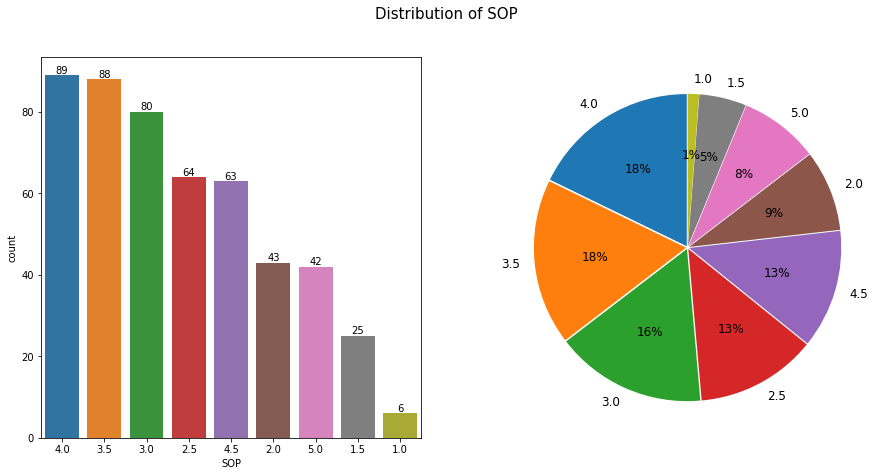

In [26]:
make_categorical_plots(df, 'SOP')

__Findings:__
- Most of the students write SOP's of average quality, rating of 3-4
- Fewer number of students write top notch SOPs, rating of 4-5

#### LOR rating

In [27]:
df['LOR '].value_counts()

3.0    99
4.0    94
3.5    86
4.5    63
2.5    50
5.0    50
2.0    46
1.5    11
1.0     1
Name: LOR , dtype: int64

In [28]:
df['LOR '].nunique()

9

__Findings:__
- The LORs are rated in 9 different numbers, ranging from 1-5 (1.0, 1.5, ..., 4.5, 5)

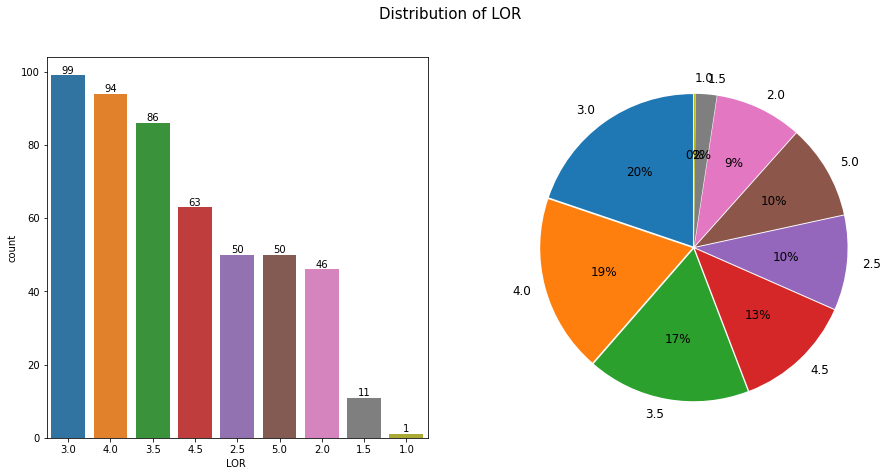

In [29]:
make_categorical_plots(df, 'LOR ')

__Findings:__
- Most of the students have LOR's of average quality, rating of 3-4
- Fewer number of students can manage top notch LORs, rating of 4-5

#### Research

In [30]:
df['Research'].value_counts()

1    280
0    220
Name: Research, dtype: int64

In [31]:
df['Research'].nunique()

2

__Findings:__
- The students are categorized into two categories, depending on if they have research experience or not.

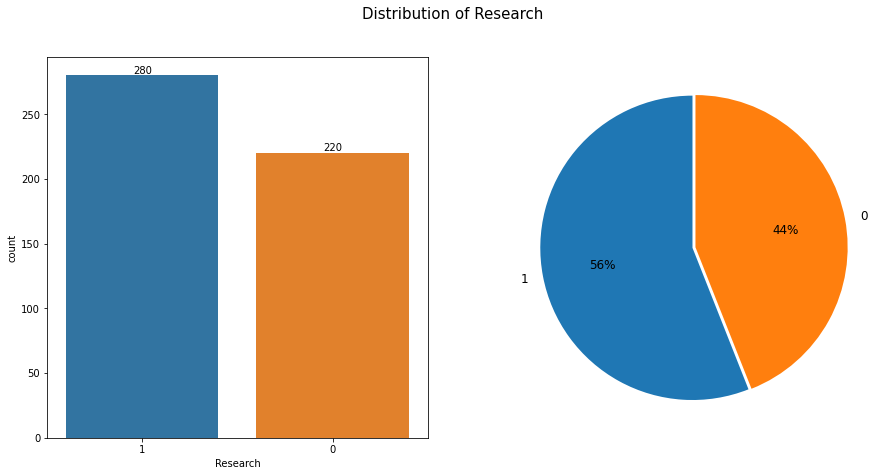

In [32]:
make_categorical_plots(df, 'Research')

__Findings:__
- The proportion of students having Research Experience is slightly higher than students without Research Experience

### Numerical Attributes

In [33]:
def make_numerical_plots(df, feature, bins='auto'):
    """
    Method to make univariate numerical plot
    """
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,7))
    f.suptitle(f'Distribution of {feature}', fontsize=15)

    # assigning a graph to each ax
    sns.boxplot(df[feature], ax=ax_box)
    sns.histplot(data=df, x=feature, ax=ax_hist, kde=True, bins=bins)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    plt.show()

#### GRE Score

In [34]:
df['GRE Score'].describe()

count    500.000000
mean     316.472000
std       11.295148
min      290.000000
25%      308.000000
50%      317.000000
75%      325.000000
max      340.000000
Name: GRE Score, dtype: float64

__Findings:__
- The GRE scores obtained ranges from 290 to 340
- The mean GRE scores obtained is ~316.5 and median value is 317

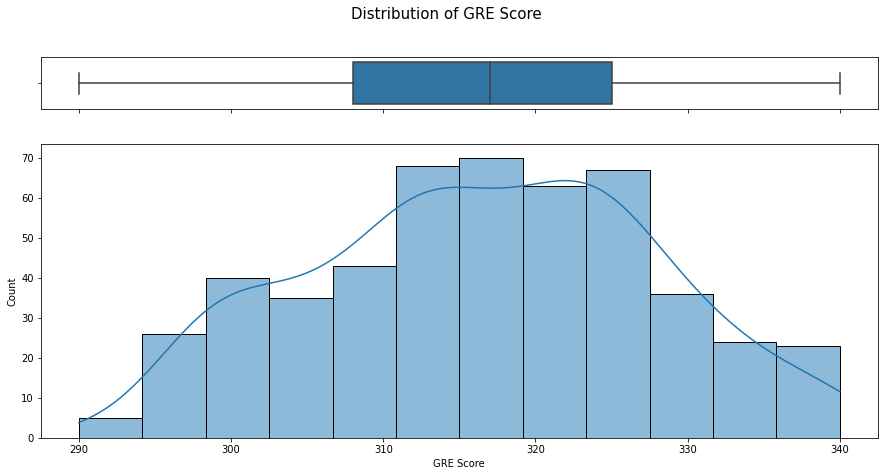

In [35]:
make_numerical_plots(df, 'GRE Score')

__Findings:__
- We do not see any outliers in the data

#### TOEFL Score

In [36]:
df['TOEFL Score'].describe()

count    500.000000
mean     107.192000
std        6.081868
min       92.000000
25%      103.000000
50%      107.000000
75%      112.000000
max      120.000000
Name: TOEFL Score, dtype: float64

__Findings:__
- The TOEFL Score of students ranges from 92 to 120
- The mean value is 107.1 and median value is 107

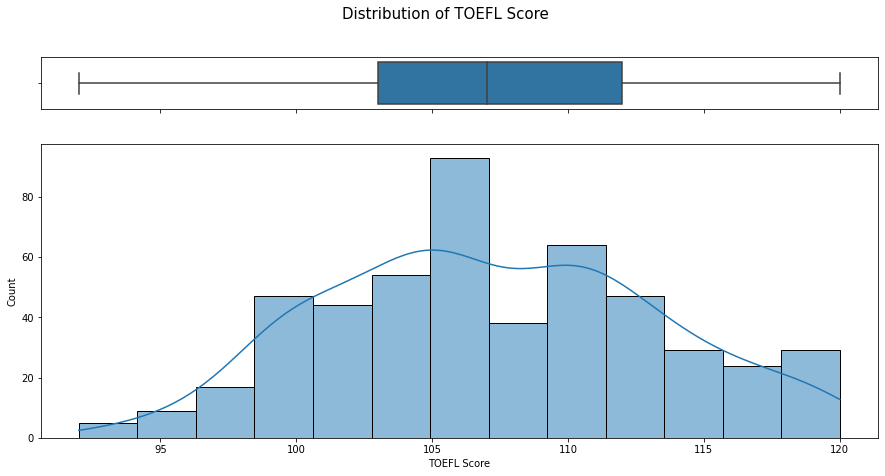

In [37]:
make_numerical_plots(df, 'TOEFL Score')

__Findings:__
- There are no outliers in the dataset

#### CGPA

In [39]:
df['CGPA'].describe()

count    500.000000
mean       8.576440
std        0.604813
min        6.800000
25%        8.127500
50%        8.560000
75%        9.040000
max        9.920000
Name: CGPA, dtype: float64

__Findings:__
- The CPGA Scores of the students ranges from 6.8 to 9.92
- The mean value is ~8.6 and median value is ~8.6

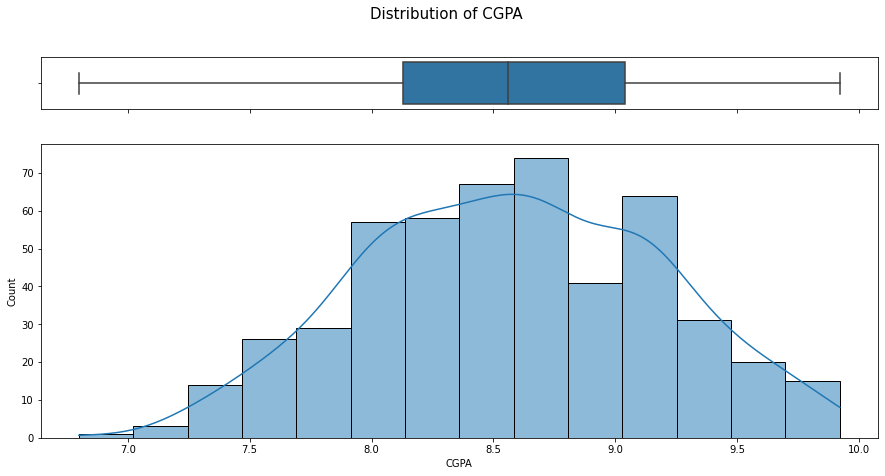

In [40]:
make_numerical_plots(df, 'CGPA')

__Findings:__
- There are no outlier points in the dataset. 


#### Chance of Admit

In [44]:
df['Chance of Admit '].describe()

count    500.00000
mean       0.72174
std        0.14114
min        0.34000
25%        0.63000
50%        0.72000
75%        0.82000
max        0.97000
Name: Chance of Admit , dtype: float64

__Findings:__
- The probabilities for chances of admission of the students ranges from 0.34 to 0.97
- The mean value is 0.72 and median value is 0.72

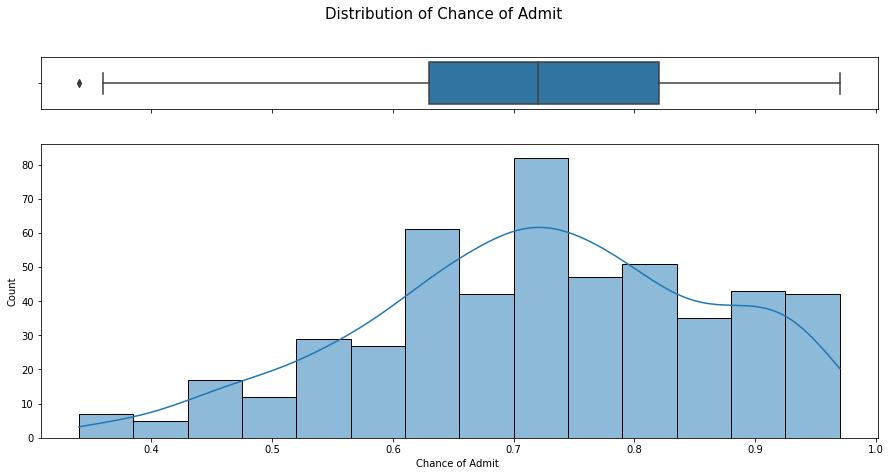

In [45]:
make_numerical_plots(df, 'Chance of Admit ')

__Findings:__
- There are outlier points in the dataset. 


In [46]:
print(f'The values lying ouside of {quantile_boundaries(df["Chance of Admit "])} are considered outliers')
print(f'There are {outlier_count(df["Chance of Admit "])} outlier data points')

The values lying ouside of (0.3450000000000001, 1.105) are considered outliers
There are 2 outlier data points


__Findings__
- We will remove the outliers

## Cleaning the data

Before we move to further analysis, we will remove the outliers that could impact our analysis:

In [47]:
def clean_data(df):

    # remove outliers from Chance of admit
    low, high = quantile_boundaries(df["Chance of Admit "])
    df = df[(df["Chance of Admit "]>=low) & (df["Chance of Admit "]<=high)]
    
    return df

In [48]:
cleaned_df = clean_data(df)
cleaned_df.shape

(498, 8)

In [49]:
print(f'Percentage of rows removed = {(len(df) - len(cleaned_df)) / len(df) * 100}')

Percentage of rows removed = 0.4


## Bivariate Analysis

The dependent variable for our problem statement is "Chance of Admit", and the remaing attribues are the independent variable. We will try to understand the factors that are important in graduate admissions and how these factors are interrelated among themselves.

### Effect of University Rating on chances of admission

In [53]:
def bi_cat_plot(df, x, target="Chance of Admit "):
    plt.figure(figsize=(15, 7))
    sns.boxplot(data=df, x=x, y=target)
    plt.title(f'Plot for {x} vs {target}', fontsize=15)
    plt.show()

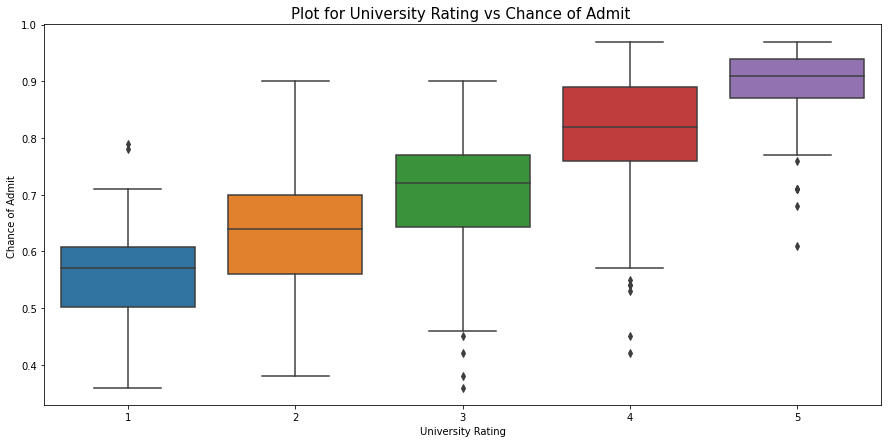

In [55]:
bi_cat_plot(cleaned_df, 'University Rating')

In [56]:
cleaned_df.groupby('University Rating')['Chance of Admit '].mean()

University Rating
1    0.562059
2    0.630726
3    0.702901
4    0.801619
5    0.888082
Name: Chance of Admit , dtype: float64

__Findings__:

- The chances of getting admission increases as the rating of the universities increases
- There are some outliers in the plot. But as we have already treated outliers, we won't remove them


### Effect of SOP Rating on chances of admission

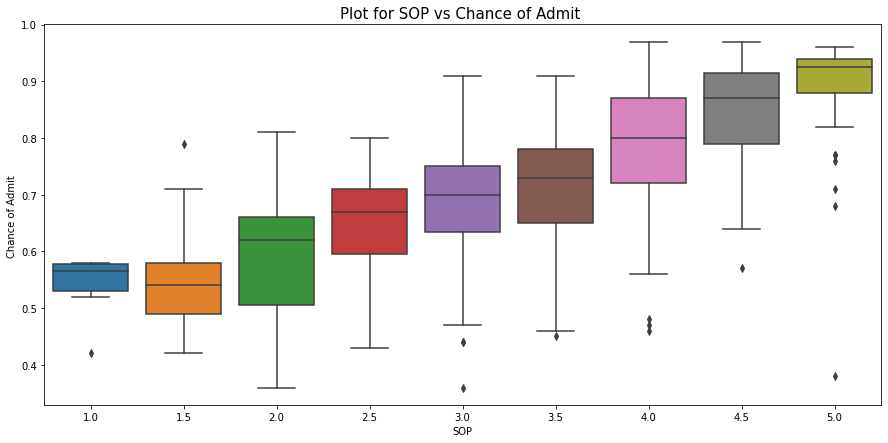

In [58]:
bi_cat_plot(cleaned_df, 'SOP')

In [59]:
cleaned_df.groupby('SOP')['Chance of Admit '].mean()

SOP
1.0    0.538333
1.5    0.546400
2.0    0.589535
2.5    0.650159
3.0    0.678500
3.5    0.712045
4.0    0.787841
4.5    0.850000
5.0    0.885000
Name: Chance of Admit , dtype: float64

__Findings__:

- The chances of getting admission increases 
as the quality of SOP increases
- There are some outliers in the plot. But as we have already treated outliers, we won't remove them

### Effect of LOR Rating on chances of admission

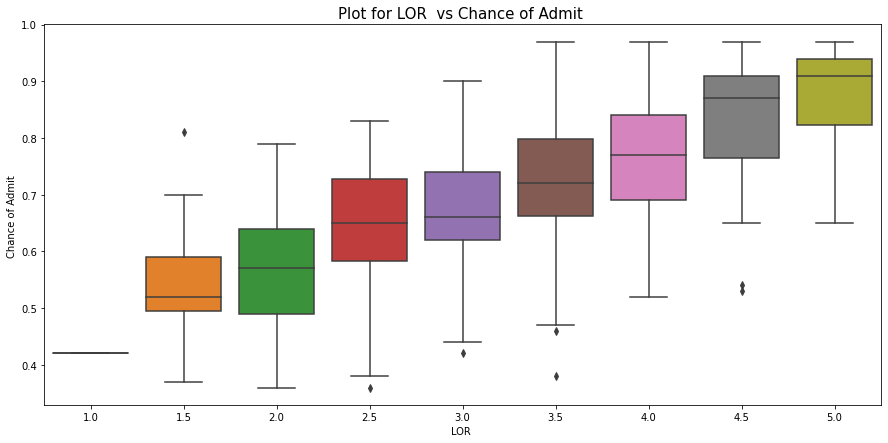

In [61]:
bi_cat_plot(cleaned_df, 'LOR ')

In [62]:
cleaned_df.groupby('LOR ')['Chance of Admit '].mean()

LOR 
1.0    0.420000
1.5    0.550000
2.0    0.573333
2.5    0.640600
3.0    0.671837
3.5    0.723023
4.0    0.764149
4.5    0.831905
5.0    0.872600
Name: Chance of Admit , dtype: float64

__Findings__:

- The chances of getting  admission increases 
as the quality of LOR increases
- There are some outliers in the plot. But as we have already treated outliers, we won't remove them

### Effect of Research on chances of admission

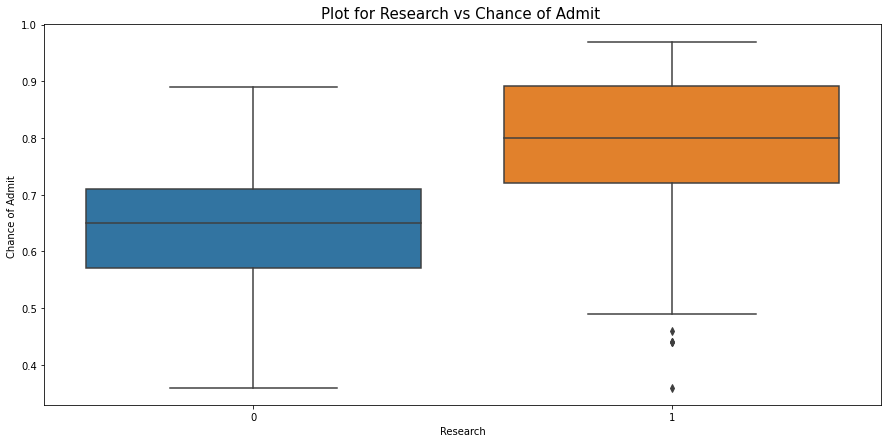

In [64]:
bi_cat_plot(cleaned_df, 'Research')

In [63]:
cleaned_df.groupby('Research')['Chance of Admit '].mean()

Research
0    0.637615
1    0.789964
Name: Chance of Admit , dtype: float64

__Findings__:

- The chances of getting admission increases if a student has a Research experience
- There are some outliers in the plot. But as we have already treated outliers, we won't remove them

### Pairplot

<Figure size 1080x504 with 0 Axes>

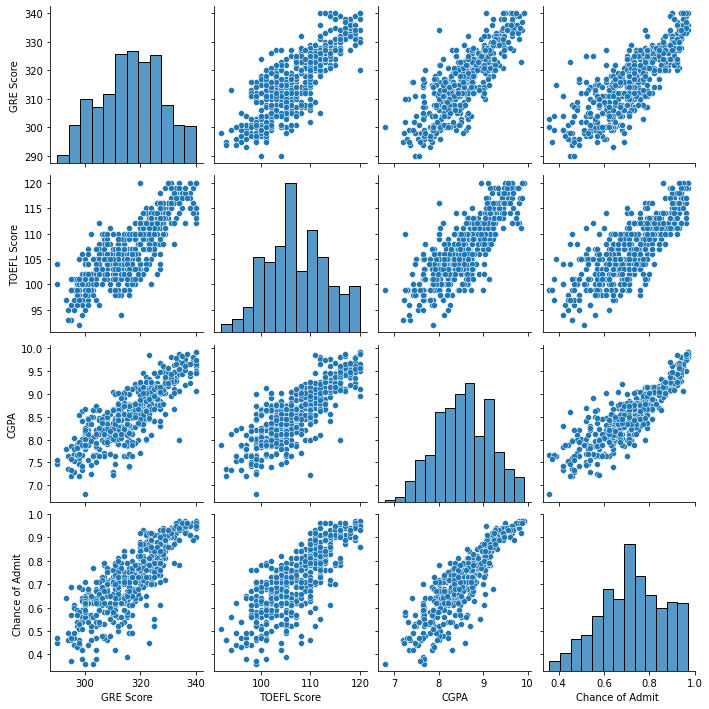

In [73]:
plt.figure(figsize=(15,7))
sns.pairplot(cleaned_df)
plt.show()

__Findings:__
- "GRE Score", "TOFEL Score", and "CGPA" have a postive correlation among themselves

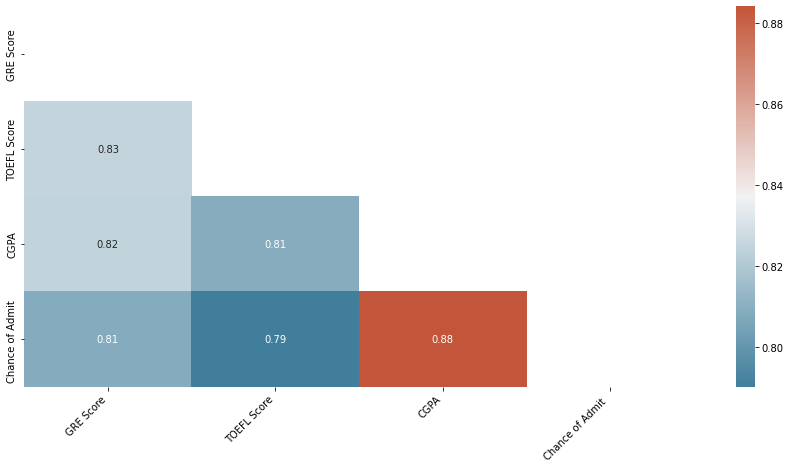

In [74]:
# Correlation between different variables
corr = cleaned_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(15, 7))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

__Findings:__
- "GRE Score", "TOEFL Score", and "CGPA" are highly correlated with the dependent feature "Chance of Admit" 
- "GRE Score", "TOEFL Score", and "CGPA" are also highly correlated among each other

## Data Preparation for Modelling

We will encode the categorical features and scale the numerical features before modelling.

In [77]:
pd.set_option('display.max_columns', None)

#### Encode categoricals

In [80]:
df = pd.get_dummies(cleaned_df, drop_first=True)
df.head(3)

,GRE Score,TOEFL Score,CGPA,Chance of Admit,University Rating_2,University Rating_3,University Rating_4,University Rating_5,SOP_1.5,SOP_2.0,SOP_2.5,SOP_3.0,SOP_3.5,SOP_4.0,SOP_4.5,SOP_5.0,LOR _1.5,LOR _2.0,LOR _2.5,LOR _3.0,LOR _3.5,LOR _4.0,LOR _4.5,LOR _5.0,Research_1
0,337,118,9.65,0.92,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,324,107,8.87,0.76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,316,104,8.00,0.72,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1


#### Scale numericals

- Before we scale the data, we will perform train-test split

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [82]:
train_df, test_df = train_test_split(df, test_size=0.2)

In [87]:
cols = ['GRE Score', 'TOEFL Score', 'CGPA']

for col in cols:
    sc = StandardScaler().fit(train_df[col].values.reshape(-1, 1))
    train_df[col] = sc.transform(train_df[col].values.reshape(-1, 1))
    test_df[col]  = sc.transform(test_df[col].values.reshape(-1, 1))


In [98]:
train_X = train_df.drop('Chance of Admit ', axis=1)
train_Y = train_df['Chance of Admit ']

test_X = test_df.drop('Chance of Admit ', axis=1)
test_Y = test_df['Chance of Admit ']

## Modelling - Iteration 1

We now have our data ready for modelling. 

In [99]:
import statsmodels.api as sm

train = sm.add_constant(train_X)
model = sm.OLS(train_Y, train).fit()

In [100]:
model.params

const                  0.610774
GRE Score              0.019675
TOEFL Score            0.019902
CGPA                   0.067323
University Rating_2   -0.018626
University Rating_3   -0.011347
University Rating_4   -0.010916
University Rating_5    0.010884
SOP_1.5                0.002919
SOP_2.0                0.013757
SOP_2.5                0.037571
SOP_3.0                0.028996
SOP_3.5                0.019269
SOP_4.0                0.028978
SOP_4.5                0.032505
SOP_5.0                0.038433
LOR _1.5               0.025825
LOR _2.0               0.071863
LOR _2.5               0.072028
LOR _3.0               0.067662
LOR _3.5               0.080138
LOR _4.0               0.093787
LOR _4.5               0.096873
LOR _5.0               0.102598
Research_1             0.026987
dtype: float64

__Summary__
- We have both positive and negative valued coefficients 


The coefficients can be interpreted as follows: 
- __GRE Score 0.01__: for 1 unit change in GRE Score, Chance of Admit increase by 0.01

The signs of coefficient decides if the impact is directly or indirectly related
- (+ve) means directly relation
- (-ve) means indirect relation

For better explainability of the dependent variable, we want the magnitude of coefficient values of the independent variables to be high. That means,  the larger the magnitude of coefficient is, higher is the impact of that feature on the dependent feature.

In [104]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_pred = model.predict(sm.add_constant(train_X))
test_pred = model.predict(sm.add_constant(test_X))

metrics = ['MAE', 'RMSE', 'R2', 'Adjusted R2']
train_scores = [
    np.round(mean_absolute_error(train_Y, train_pred), 3),
    np.round(mean_squared_error(train_Y, train_pred), 3),
    np.round(r2_score(train_Y, train_pred), 3),
    np.round(1 - (1-r2_score(train_Y, train_pred))*(len(train_Y)-1)/(len(train_Y)-train_X.shape[1]-1), 3)
]

test_scores = [
    np.round(mean_absolute_error(test_Y, test_pred), 3),
    np.round(mean_squared_error(test_Y, test_pred), 3),
    np.round(r2_score(test_Y, test_pred), 3),
    np.round(1 - (1-r2_score(test_Y, test_pred))*(len(test_Y)-1)/(len(test_Y)-train_X.shape[1]-1), 3)
]

x = PrettyTable(["Sl no", "Metric", "Train Score", "Test Score"])
i = 1
for a, b, c in zip(metrics, train_scores, test_scores):
    x.add_row([i, a, b, c])
    x.add_row([' ', ' ', ' ', ' '])
    i += 1
print(x)

+-------+-------------+-------------+------------+
| Sl no |    Metric   | Train Score | Test Score |
+-------+-------------+-------------+------------+
|   1   |     MAE     |    0.041    |   0.045    |
|       |             |             |            |
|   2   |     RMSE    |    0.003    |   0.004    |
|       |             |             |            |
|   3   |      R2     |    0.832    |   0.808    |
|       |             |             |            |
|   4   | Adjusted R2 |    0.821    |   0.747    |
|       |             |             |            |
+-------+-------------+-------------+------------+


__Findings__
- The R2 score is descent. 
- We will try to remove features with lesser predictive power so we can have a model that is much simple, and more interpretable
- As we have already used all the features in this model, we can expect a decrease in the score in our next model.

## Testing assumptions of the linear regression model:

In [93]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Chance of Admit    R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     80.28
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          2.66e-129
Time:                        15:52:17   Log-Likelihood:                 572.15
No. Observations:                 398   AIC:                            -1096.
Df Residuals:                     374   BIC:                            -1001.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6108      0.032     19.363      0.000       0.549       0.673
GRE Score               0.0197      0.006      3.071      0.002       0.007       0.032
TOEFL Score             0.0199      0.006      3.287      0.001       0.008       0.032
CGPA                    0.0673      0.007     10.189      0.000       0.054       0.080
University Rating_2    -0.0186      0.015     -1.230      0.219      -0.048       0.011
University Rating_3    -0.0113      0.016     -0.701      0.483      -0.043       0.020
University Rating_4    -0.0109      0.018     -0.610      0.543      -0.046       0.024
University Rating_5     0.0109      0.020      0.542      0.588      -0.029       0.050
SOP_1.5                 0.0029      0.038      0.077      0.938      -0.071       0.077
SOP_2.0                 0.0138      0.038      0.363      0.717      -0.061       0.088
SOP_2.5                 0.0376      0.038      0.984      0.326      -0.038       0.113
SOP_3.0                 0.0290      0.038      0.755      0.451      -0.047       0.105
SOP_3.5                 0.0193      0.039      0.495      0.621      -0.057       0.096
SOP_4.0                 0.0290      0.039      0.737      0.461      -0.048       0.106
SOP_4.5                 0.0325      0.040      0.807      0.420      -0.047       0.112
SOP_5.0                 0.0384      0.041      0.940      0.348      -0.042       0.119
LOR _1.5                0.0258      0.017      1.509      0.132      -0.008       0.059
LOR _2.0                0.0719      0.011      6.434      0.000       0.050       0.094
LOR _2.5                0.0720      0.011      6.773      0.000       0.051       0.093
LOR _3.0                0.0677      0.008      7.962      0.000       0.051       0.084
LOR _3.5                0.0801      0.008      9.448      0.000       0.063       0.097
LOR _4.0                0.0938      0.009     10.571      0.000       0.076       0.111
LOR _4.5                0.0969      0.010      9.386      0.000       0.077       0.117
LOR _5.0                0.1026      0.012      8.312      0.000       0.078       0.127
Research_1              0.0270      0.008      3.490      0.001       0.012       0.042
==============================================================================
Omnibus:                       88.636   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.906
Skew:                          -1.082   Prob(JB):                     1.45e-49
Kurtosis:                       5.979   Cond. No.                     8.92e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-29. T

__Findings:__
- The variance explained by the model is good, we have __R2=0.832__ and __Adjusted R2=0.821__
- The model suggests the existence of multicollinearity among features
- The p-value column suggests (t-test for linear regression coefficients), there are some columns that have no impact on the target variables: "SOP", "University Rating"


We will remove the variables that have less impact on the model. We want a  model that is simple, and features having higher predictive power.

### Multicollinearity check by VIF score

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [106]:
vif = pd.DataFrame()
vif['Features'] = train_X.columns
vif['VIF'] = [variance_inflation_factor(train_X.values, i) for i in range(train_X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
19,LOR _3.5,29.89
18,LOR _3.0,28.99
20,LOR _4.0,28.38
12,SOP_4.0,25.08
11,SOP_3.5,24.33
10,SOP_3.0,23.40
21,LOR _4.5,21.14
13,SOP_4.5,19.47
9,SOP_2.5,19.06
14,SOP_5.0,15.98


__Findings:__
- The columns "LOR", "SOP", "University Rating" have high multicollinearity. We should not use them in our model

### Mean of residuals

In [109]:
errors = train_pred - train_Y
print(f'Mean of Residuals = {np.round(errors.mean(), 3)}')

Mean of Residuals = -0.0


__Findings:__
- The mean of residuals is approximately zero (0). This assumption is satisfied

### Linearity of variables


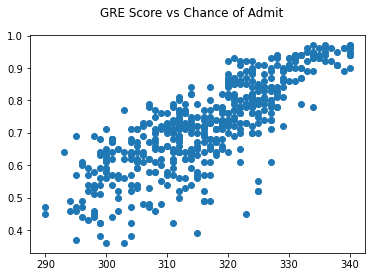

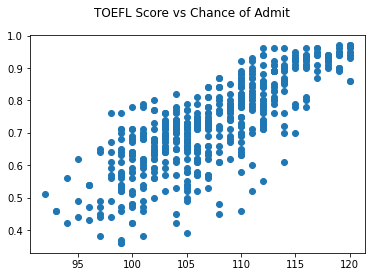

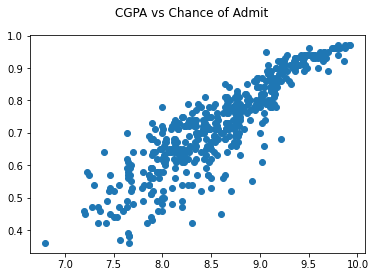

In [120]:
nums = ['GRE Score', 'TOEFL Score', 'CGPA']

for col in nums:
    plt.figure()
    plt.scatter(cleaned_df[col], cleaned_df['Chance of Admit '])
    plt.suptitle(f'{col} vs Chance of Admit', fontsize=12)
    plt.show()

__Findings__
- There seems to be a linear trend for the numerical variables

### Normality of Residuals

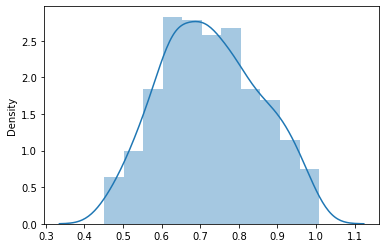

In [122]:
sns.distplot(train_pred)
plt.show()

__Findings__
- The residuals almost looks like a normal distribution

### Test for Homoscedasticity

The assumption of homoscedasticity is a vital assumption for linear regression. If this assumption is violated, then the standard errors will be biased.

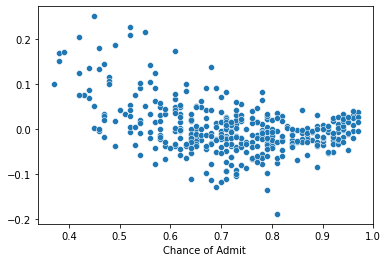

In [ ]:
sns.scatterplot(train_Y, errors)
plt.show()

We will use the Goldfeld-Quandt homoskedasticity test to check the homoscedasticity.

- Null Hypothesis, Ho: the variance in the two sub-samples are the same
- Alternate Hypotheses, Ha: the variance in the two sub-samples are not same

We choose alpha value of 0.05



In [ ]:
import statsmodels

statsmodels.stats.diagnostic.het_goldfeldquandt(errors, train_X)

(1.3303603718701187, 0.029904655843546037, 'increasing')

In [ ]:
import statsmodels
from statsmodels.compat import lzip

name = ['F-statistic', 'p-value']
test = statsmodels.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog, alternative='two-sided')
lzip(name, test)

[('F-statistic', 1.3303603718701187), ('p-value', 0.059809311687092075)]

In [ ]:
alpha = 0.05
if test[1] > 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We fail to reject the Null Hypothesis Ho


__Findings:__
- The data follows the assumption of homoscedasticity

## Modelling - Iteration 2

In iteration 1, we detected multicollinearity and features with very low coefficient. In this iteration we will avoid using them during training. We will only use the columns that are less affected by multicollinearity and having good predictive power.

In [138]:
top_cols = ['CGPA', 'GRE Score', 'TOEFL Score', 'Research_1']

train = sm.add_constant(train_X[top_cols])
model = sm.OLS(train_Y, train).fit()

In [139]:
model.params

const          0.708935
CGPA           0.081693
GRE Score      0.018696
TOEFL Score    0.022958
Research_1     0.029248
dtype: float64

__Summary__

The coefficients can be interpreted as follows: 
- __GRE Score 0.01__: for 1 unit change in GRE Score, Chance of Admit increases by 0.018

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_pred = model.predict(sm.add_constant(train_X[top_cols]))
test_pred = model.predict(sm.add_constant(test_X[top_cols]))

metrics = ['MAE', 'RMSE', 'R2', 'Adjusted R2']
train_scores = [
    np.round(mean_absolute_error(train_Y, train_pred), 3),
    np.round(mean_squared_error(train_Y, train_pred), 3),
    np.round(r2_score(train_Y, train_pred), 3),
    np.round(1 - (1-r2_score(train_Y, train_pred))*(len(train_Y)-1)/(len(train_Y)-train_X.shape[1]-1), 3)
]

test_scores = [
    np.round(mean_absolute_error(test_Y, test_pred), 3),
    np.round(mean_squared_error(test_Y, test_pred), 3),
    np.round(r2_score(test_Y, test_pred), 3),
    np.round(1 - (1-r2_score(test_Y, test_pred))*(len(test_Y)-1)/(len(test_Y)-train_X.shape[1]-1), 3)
]

x = PrettyTable(["Sl no", "Metric", "Train Score", "Test Score"])
i = 1
for a, b, c in zip(metrics, train_scores, test_scores):
    x.add_row([i, a, b, c])
    x.add_row([' ', ' ', ' ', ' '])
    i += 1
print(x)

+-------+-------------+-------------+------------+
| Sl no |    Metric   | Train Score | Test Score |
+-------+-------------+-------------+------------+
|   1   |     MAE     |    0.043    |   0.044    |
|       |             |             |            |
|   2   |     RMSE    |    0.004    |   0.004    |
|       |             |             |            |
|   3   |      R2     |    0.814    |   0.804    |
|       |             |             |            |
|   4   | Adjusted R2 |    0.802    |   0.741    |
|       |             |             |            |
+-------+-------------+-------------+------------+


__Findings:__
- Just by using 4 columns viz "TOEFL Score", "GRE Score", "CGPA", and "Research", we are able to get similar performance as compared to a model that uses all the columns.
- The R2 value we obtained suggests we have a descent model.

## Testing assumptions of the linear regression model:

In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Chance of Admit    R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     431.0
Date:                Tue, 19 Apr 2022   Prob (F-statistic):          3.17e-142
Time:                        17:28:12   Log-Likelihood:                 552.80
No. Observations:                 398   AIC:                            -1096.
Df Residuals:                     393   BIC:                            -1076.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7089      0.005    134.835      0.000       0.699       0.719
CGPA            0.0817      0.006     13.802      0.000       0.070       0.093
GRE Score       0.0187      0.006      2.894      0.004       0.006       0.031
TOEFL Score     0.0230      0.006      3.812      0.000       0.011       0.035
Research_1      0.0292      0.008      3.788      0.000       0.014       0.044
==============================================================================
Omnibus:                       96.304   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.753
Skew:                          -1.204   Prob(JB):                     2.12e-50
Kurtosis:                       5.827   Cond. No.                         5.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Findings:__
- The variance explained by the model is good, we have __R2=0.814__ and __Adjusted R2=0.812__
- The p-value column suggests (t-test for linear regression coefficients), the columns have non-zero coeffiencts

The performance of this model is comparable to the one built in the first iteration. But this model is much more simple, making the model more explainable.

### Multicollinearity check by VIF score

In [143]:
vif = pd.DataFrame()
vif['Features'] = train_X[top_cols].columns
vif['VIF'] = [variance_inflation_factor(train_X[top_cols].values, i) for i in range(train_X[top_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,GRE Score,4.18
2,TOEFL Score,3.90
0,CGPA,3.75
3,Research_1,1.20


__Findings:__
- There is no multicollinearity in the model

### Mean of residuals

In [144]:
errors = train_pred - train_Y
print(f'Mean of Residuals = {np.round(errors.mean(), 3)}')

Mean of Residuals = -0.0


__Findings:__
- The mean of residuals is approximately zero (0). This assumption is satisfied

### Linearity of variables


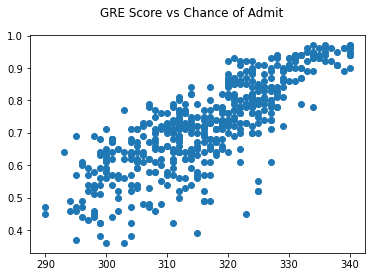

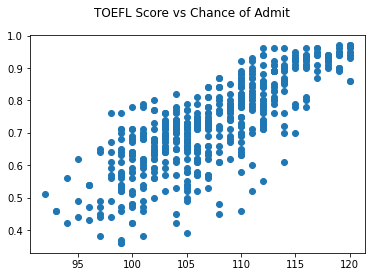

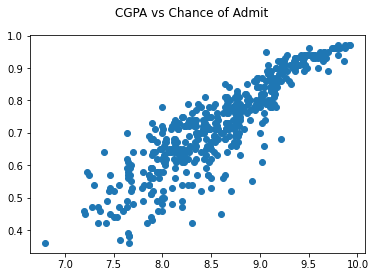

In [147]:
nums = ['GRE Score', 'TOEFL Score', 'CGPA']

for col in nums:
    plt.figure()
    plt.scatter(cleaned_df[col], cleaned_df['Chance of Admit '])
    plt.suptitle(f'{col} vs Chance of Admit', fontsize=12)
    plt.show()

__Findings__
- There seems to be a linear trend for the numerical variables

### Normality of Residuals

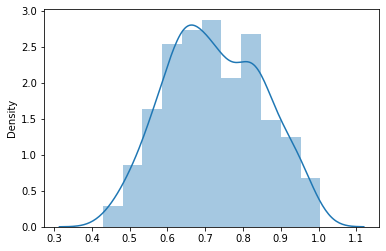

In [148]:
sns.distplot(train_pred)
plt.show()

__Findings__
- The residuals almost looks like a normal distribution

### Test for Homoscedasticity

The assumption of homoscedasticity is a vital assumption for linear regression. If this assumption is violated, then the standard errors will be biased.

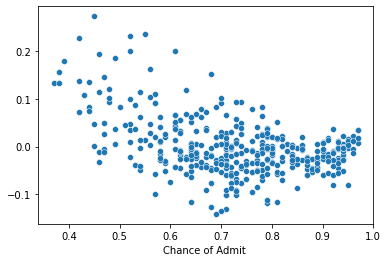

In [149]:
sns.scatterplot(train_Y, errors)
plt.show()

We will use the Goldfeld-Quandt homoskedasticity test to check the homoscedasticity.

- Null Hypothesis, Ho: the variance in the two sub-samples are the same
- Alternate Hypotheses, Ha: the variance in the two sub-samples are not same

We choose alpha value of 0.05



In [151]:
import statsmodels
from statsmodels.compat import lzip

name = ['F-statistic', 'p-value']
test = statsmodels.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog, alternative='two-sided')
lzip(name, test)

[('F-statistic', 1.2199056002835658), ('p-value', 0.1671620454705086)]

In [153]:
alpha = 0.05
if test[1] > 0.05:
    print('We fail to reject the Null Hypothesis Ho')
else:
    print('We reject the Null Hypothesis Ho')

We fail to reject the Null Hypothesis Ho


__Findings:__
- The data follows the assumption of homoscedasticity

# Conclusion
- The model built using only the columns "GRE Score", "TOEFL Score", "CGPA", and "Research" explains variability in the target as much the model built using all the columns.
- The model build in the 2nd iteration fulfills all the assumptions of linear regression. 
- In real world, we will prefer to deploy Model 2 instead of Model 1. Because, Model 2 is much simpler and explainable, and the performance score still remains comparable.
-The "CGPA" feature has the highest impact on the chances of admission of a student, followed by "Research", "TOEFL Score", and "GRE Score"

# Recommendations:



In [4]:
from prettytable import PrettyTable

observations = [
    """The chances of getting admission increases as the quality 
    of SOP increases.""",

    """CGPA has the highest coefficient magnitude.""" ,

    """Students having research experience have higher chances
    of getting admissions."""
    ]


recommendations = [
    """SOP is as important as marks for getting admission.""" ,

    """Students should be advised to focus more on CGPA scores
    than GRE and TOEFL scores to improve his chances of getting
    admission.""",

    """Students should be encouraged to pick research projects in
    their college.""",
    ]

x = PrettyTable(["Sl no", "Observations", "Recommendations"])
i = 1
for a, b in zip(observations, recommendations):
    x.add_row([i, a, b])
    x.add_row([' ', ' ', ' '])
    i += 1
print(x)

+-------+------------------------------------------------------------+-----------------------------------------------------------------+
| Sl no |                        Observations                        |                         Recommendations                         |
+-------+------------------------------------------------------------+-----------------------------------------------------------------+
|   1   | The chances of getting admission increases as the quality  |       SOP is as important as marks for getting admission.       |
|       |                       of SOP increases.                    |                                                                 |
|       |                                                            |                                                                 |
|   2   |        CGPA has the highest coefficient magnitude.         |     Students should be advised to focus more on CGPA scores     |
|       |                                